In [3]:
!pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.1 MB/s eta 0:00:00


In [4]:
!pip install gym[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 31.4 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376476 sha256=e9ee1d9099d09fe4000d5386e23d33fb6ffcd3dceeb5aa207c3595699b589960
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.6.1
    Uninstalling pygame-2.6.1:
      Successfully uninstalled pygame-2.6.1


In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import gym
import wandb
import argparse
from torch.nn.utils import clip_grad_norm_
import copy
import random
from collections import deque, namedtuple

In [6]:
class Config:
    def __init__(self):
        self.run_name = "SAC_discrete"
        self.episodes = 1000
        self.buffer_size = 100000
        self.seed = 1
        self.env = "LunarLander-v2"
        self.save_every = 100
        self.save_name = "SAC"
        self.batch_size = 256

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

In [7]:

class Actor(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=32):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        action_probs = self.softmax(self.fc3(x))
        return action_probs

    def evaluate(self, state, epsilon=1e-6):
        action_probs = self.forward(state)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()
        z = action_probs == 0.0
        z = z.float() * 1e-8
        log_action_probabilities = torch.log(action_probs + z)
        return action.detach().cpu(), action_probs, log_action_probabilities

    def get_det_action(self, state):
        action_probs = self.forward(state)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()
        return action.detach().cpu()

class Critic(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=32, seed=1):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [8]:

class SAC:
    def __init__(self, state_size, action_size, device):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device
        self.gamma = 0.99
        self.tau = 1e-2
        hidden_size = 256
        learning_rate = 5e-4
        self.clip_grad_param = 1
        self.target_entropy = -action_size
        self.log_alpha = torch.tensor([0.0], requires_grad=True)
        self.alpha = self.log_alpha.exp().detach()
        self.alpha_optimizer = optim.Adam(params=[self.log_alpha], lr=learning_rate)

        self.actor_local = Actor(state_size, action_size, hidden_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=learning_rate)

        self.critic1 = Critic(state_size, action_size, hidden_size, 2).to(device)
        self.critic2 = Critic(state_size, action_size, hidden_size, 1).to(device)

        self.critic1_target = Critic(state_size, action_size, hidden_size).to(device)
        self.critic1_target.load_state_dict(self.critic1.state_dict())
        self.critic2_target = Critic(state_size, action_size, hidden_size).to(device)
        self.critic2_target.load_state_dict(self.critic2.state_dict())

        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=learning_rate)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=learning_rate)

    def get_action(self, state):
        state = torch.from_numpy(state).float().to(self.device)
        with torch.no_grad():
            action = self.actor_local.get_det_action(state)
        return action.numpy()

    def calc_policy_loss(self, states, alpha):
        _, action_probs, log_pis = self.actor_local.evaluate(states)
        q1 = self.critic1(states)
        q2 = self.critic2(states)
        min_Q = torch.min(q1, q2)
        actor_loss = (action_probs * (alpha * log_pis - min_Q)).sum(1).mean()
        log_action_pi = torch.sum(log_pis * action_probs, dim=1)
        return actor_loss, log_action_pi

    def learn(self, step, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        current_alpha = self.alpha
        actor_loss, log_pis = self.calc_policy_loss(states, current_alpha.to(self.device))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        alpha_loss = -(self.log_alpha.exp() * (log_pis + self.target_entropy).detach()).mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        self.alpha = self.log_alpha.exp().detach()

        with torch.no_grad():
            _, action_probs, log_pis = self.actor_local.evaluate(next_states)
            Q_target1_next = self.critic1_target(next_states)
            Q_target2_next = self.critic2_target(next_states)
            Q_target_next = action_probs * (torch.min(Q_target1_next, Q_target2_next) - self.alpha.to(self.device) * log_pis)
            Q_targets = rewards + (gamma * (1 - dones) * Q_target_next.sum(dim=1).unsqueeze(-1))

        q1 = self.critic1(states).gather(1, actions.long())
        q2 = self.critic2(states).gather(1, actions.long())
        critic1_loss = 0.5 * F.mse_loss(q1, Q_targets)
        critic2_loss = 0.5 * F.mse_loss(q2, Q_targets)
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward(retain_graph=True)
        self.critic1_optimizer.step()
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()
        self.soft_update(self.critic1, self.critic1_target)
        self.soft_update(self.critic2, self.critic2_target)

        return actor_loss.item(), alpha_loss.item(), critic1_loss.item(), critic2_loss.item(), current_alpha

    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)


In [9]:

class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, device):
        self.device = device
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.stack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [10]:

def train():
    config = Config()
    np.random.seed(config.seed)
    random.seed(config.seed)
    torch.manual_seed(config.seed)
    env = gym.make("LunarLander-v2")
    env.seed(config.seed)
    env.action_space.seed(config.seed)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    agent = SAC(state_size=env.observation_space.shape[0], action_size=env.action_space.n, device=device)
    buffer = ReplayBuffer(buffer_size=config.buffer_size, batch_size=config.batch_size, device=device)
    time_steps_per_episode = []
    episode_rewards = []
    n_steps = 0
    for _ in range(10000):
        state = env.reset()
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)
        buffer.add(state, action, reward, next_state, done)
    for i in range(1, config.episodes + 1):
        state = env.reset()
        total_reward = 0
        while True:
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            buffer.add(state, action, reward, next_state, done)
            policy_loss, alpha_loss, critic1_loss, critic2_loss, current_alpha = agent.learn(i, buffer.sample(), agent.gamma)
            state = next_state
            n_steps += 1
            total_reward += reward
            if done:
                time_steps_per_episode.append(n_steps)
                episode_rewards.append(total_reward)
                break

        print(f"Episode {i}, Total Reward: {total_reward}, Policy Loss: {policy_loss}, Alpha Loss: {alpha_loss}")

if __name__ == "__main__":
    train()

<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarn

Episode 1, Total Reward: -143.64872023017114, Policy Loss: -2.3976807594299316, Alpha Loss: 4.954935550689697
Episode 2, Total Reward: -118.70741016498907, Policy Loss: -3.910060167312622, Alpha Loss: 4.188451766967773
Episode 3, Total Reward: -334.7264220250148, Policy Loss: -5.942078590393066, Alpha Loss: 3.8827168941497803
Episode 4, Total Reward: -352.2418667658658, Policy Loss: -7.417601585388184, Alpha Loss: 3.575368881225586
Episode 5, Total Reward: -306.200834819921, Policy Loss: -8.460752487182617, Alpha Loss: 3.362731456756592
Episode 6, Total Reward: -24.374974577682664, Policy Loss: -10.107425689697266, Alpha Loss: 3.0406806468963623
Episode 7, Total Reward: -233.6757127018692, Policy Loss: -11.919800758361816, Alpha Loss: 2.796858787536621
Episode 8, Total Reward: -76.21248212196599, Policy Loss: -14.852890014648438, Alpha Loss: 2.3685848712921143
Episode 9, Total Reward: -107.56479802741342, Policy Loss: -21.6179256439209, Alpha Loss: 1.6241649389266968
Episode 10, Total 

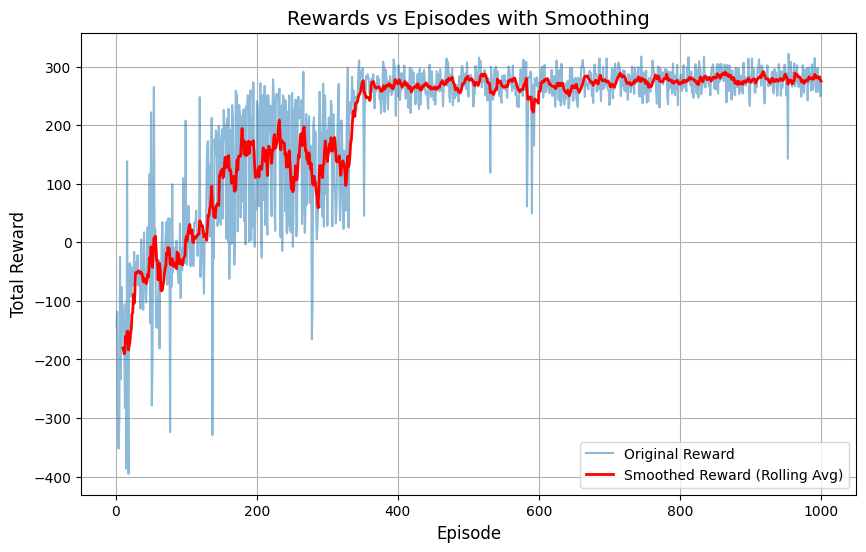

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Read the file content
file_path = 'rewards.txt'
with open(file_path, 'r') as file:
    lines = file.readlines()

# Extract episode and total reward data using regex
episodes = []
total_rewards = []

for line in lines:
    match = re.search(r'Episode (\d+), Total Reward: ([\-\d\.]+)', line)
    if match:
        episodes.append(int(match.group(1)))
        total_rewards.append(float(match.group(2)))

# Create a DataFrame for easier handling
data = pd.DataFrame({'Episode': episodes, 'Total Reward': total_rewards})

# Compute rolling mean with a window size of 10 episodes
window_size = 10
data['Smoothed Reward'] = data['Total Reward'].rolling(window=window_size, center=False).mean()

# Plot the original data and the smoothed curve
plt.figure(figsize=(10, 6))
plt.plot(data['Episode'], data['Total Reward'], label='Original Reward', alpha=0.5)
plt.plot(data['Episode'], data['Smoothed Reward'], label='Smoothed Reward (Rolling Avg)', color='red', linewidth=2)
plt.title('Rewards vs Episodes with Smoothing', fontsize=14)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Total Reward', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

